Импортируем все необходимые библиотеки

In [78]:
# pandas
import pandas as pd
from pandas import DataFrame
import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

Загружаем наши данные и смотрим на их состояние

In [79]:
train_df = pd.read_csv("titanic/train.csv")
test_df    = pd.read_csv("titanic/test.csv")

test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [80]:
train_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

Легко заметить, что в тренировочном датасете у нас не хватает данных о возрасте, каюте и месте погружения пассажира на корабль.
В тестовом датасете нам не хватает данных о возрасте, каюте и плате за пребывание на корабле.

Для начала разберемся с полем Embarked в тренировочном датасете, которое отвечает за место погружения.
Проверим, в каких строках у нас отсутствуют данные.

In [81]:
# Embarked
train_df[train_df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Посмотрим на общею зависимость шанса выживания от пункта погружения.

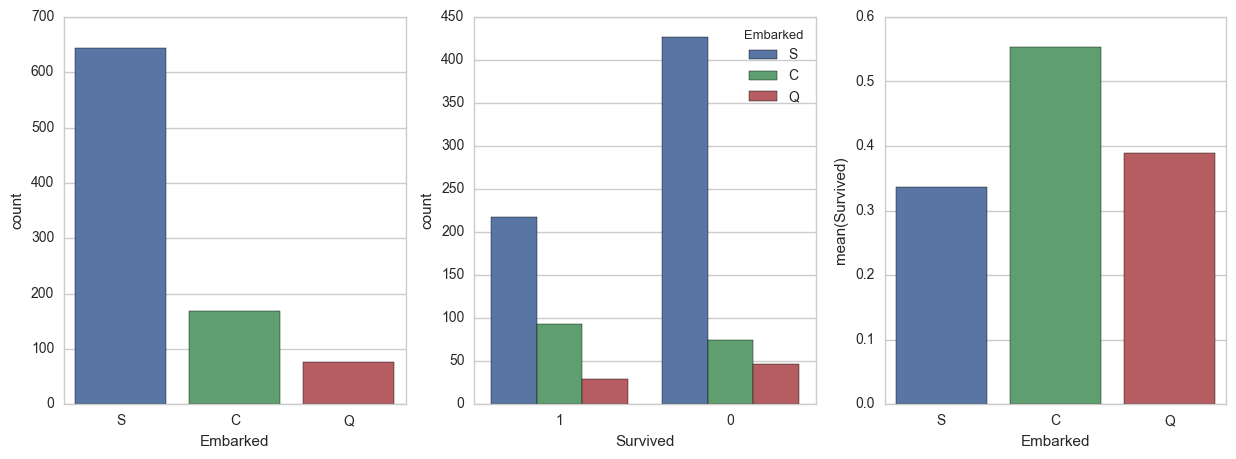

In [82]:
# plot
#sns.factorplot('Embarked','Survived', data=train_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data=train_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = train_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

Смотрим на другие возможные зависимости, которые могли б нам указать на то, где пассажиры попали на корабль.

In [83]:
train_df.loc[train_df.Ticket == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [84]:
print( 'C == ' + str( len(train_df.loc[train_df.Pclass == 1].loc[train_df.Fare > 75].loc[train_df.Fare < 85].loc[train_df.Embarked == 'C']) ) )
print( 'S == ' + str( len(train_df.loc[train_df.Pclass == 1].loc[train_df.Fare > 75].loc[train_df.Fare < 85].loc[train_df.Embarked == 'S']) ) )

C == 16
S == 13


In [85]:
train_df = train_df.set_value(train_df.Embarked.isnull(), 'Embarked', 'C')

In [86]:
train_df.loc[train_df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Теперь исправим пустое поле с платой за путешествение в тестовом датасете.

In [87]:
test_df[test_df.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Давайте посмотрим на всех пассажиров, с похожими другими признаками.

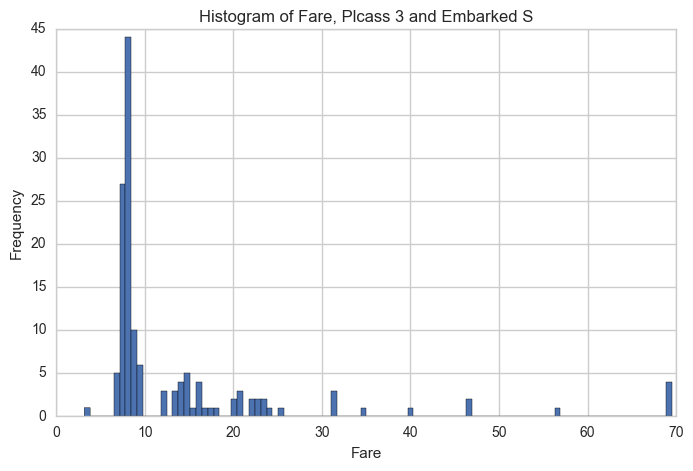

In [88]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

test_df[(test_df.Pclass==3)&(test_df.Embarked=='S')].Fare.hist(bins=100, ax=ax)
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Fare, Plcass 3 and Embarked S')


In [89]:
print ("The top 5 most common value of Fare")
test_df[(test_df.Pclass==3)&(test_df.Embarked=='S')].Fare.value_counts().head()

The top 5 most common value of Fare


8.0500    17
7.8958    10
7.7750    10
7.8542     8
8.6625     8
Name: Fare, dtype: int64

Делаем вывод, что вероятнее всего плата была в таком размере.

In [90]:
test_df.set_value(test_df.Fare.isnull(), 'Fare', 8.05)
test_df.loc[test_df.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Теперь разберемся с полем Возраста в тренировочном датасете. Ему нужно уделить больше внимания, т.к. это очень важный признак, который сильно влияет на выживаемость пассажиров.

In [91]:
test_df.loc[test_df.Age.isnull()].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S
29,921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


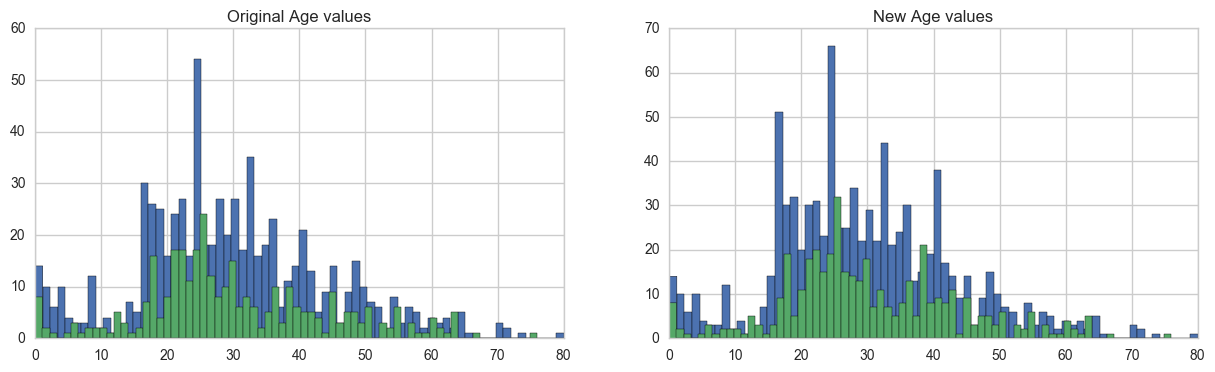

In [92]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values')
axis2.set_title('New Age values')

# среднее, дисперсия и пустые значение в тестовом датасете
average_age_train   = train_df["Age"].mean()
std_age_train       = train_df["Age"].std()
count_nan_age_train = train_df["Age"].isnull().sum()

# среднее, дисперсия и пустые значение в тестовом датасете
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# генерируем случайные значения (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_train - std_age_train, average_age_train + std_age_train, size = count_nan_age_train)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# строим гистограму возраста до изменений (пустые конвертим в инты)
train_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# заполняем случайными значениями пустые поля с возрастом
train_df["Age"][np.isnan(train_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# конвертим флоаты в инты
train_df['Age'] = train_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)
        
# гистограма нового возраста
train_df['Age'].hist(bins=70, ax=axis2)
test_df['Age'].hist(bins=70, ax=axis2)

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


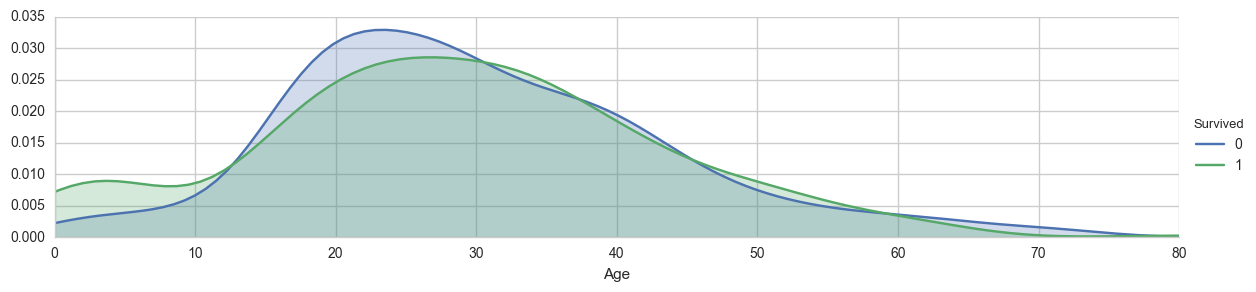

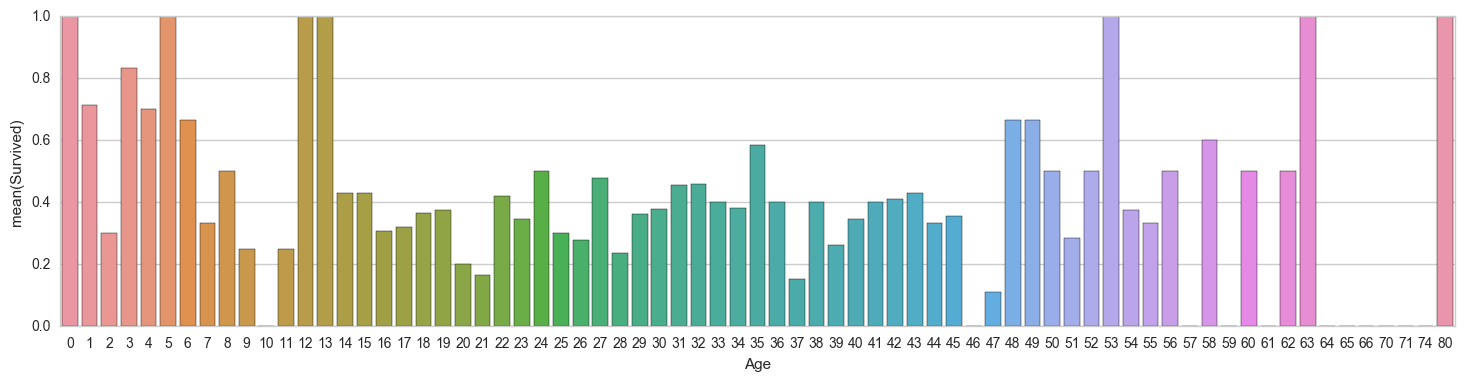

In [93]:
# Еще немного графиков

# пик выживаемости в зависимости от возраста
facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()

# средняя выживаемость по возрасту
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = train_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [94]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null int32
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(1), int32(1), int64(5), object(5)
memory usage: 80.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null int32
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null

В именах есть приставки, с ними тоже можно кое-что сделать, т.к. социальный статус может быть важным признаком выживаемости.

In [95]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Nobel",
                    "Don":        "Nobel",
                    "Sir" :       "Nobel",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Nobel",
                    "Dona":       "Nobel",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Nobel"
                    } 

train_df['Title'] = train_df['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])
test_df['Title'] = test_df['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])

train_df.head(100)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,Mr
5,6,0,3,"Moran, Mr. James",male,26,0,0,330877,8.4583,NaN,Q,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C,Mrs


Вместо двух полей указывающий на наличие партнера (Parch) или родственника (SibSp), сделаем одно поле FamilySize

In [96]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch']
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch']

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,Mr,0


Пол тоже очень важный признак, но если вы смотрели фильм титаник, то наверное помните "Сначала женщин и детей." Поэтому предлагаю сооздать новый признак, который будет учитывать как пол, так и возраст

In [97]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
train_df['Person'] = train_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Person
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,Mr,1,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Mrs,1,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs,1,female
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,Mr,0,male


In [98]:
train_df.info()
print("----------------------------")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null int32
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Title          891 non-null object
FamilySize     891 non-null int64
Person         891 non-null object
dtypes: float64(1), int32(1), int64(6), object(7)
memory usage: 101.0+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null obj

Убедились, что теперь наши данные в порядке и переходим к откидыванию лишнего.

In [99]:
train_df.drop(labels=['PassengerId', 'Name', 'Cabin', 'Ticket', 'SibSp', 'Parch', 'Sex'], axis=1, inplace=True)
test_df.drop(labels=['Name', 'Cabin', 'Ticket', 'SibSp', 'Parch', 'Sex'], axis=1, inplace=True)

In [100]:
train_df.head()

,Survived,Pclass,Age,Fare,Embarked,Title,FamilySize,Person
0,0,3,22,7.2500,S,Mr,1,male
1,1,1,38,71.2833,C,Mrs,1,female
2,1,3,26,7.9250,S,Miss,0,female
3,1,1,35,53.1000,S,Mrs,1,female
4,0,3,35,8.0500,S,Mr,0,male


У нас есть дискретные переменные и нам стоило б их закодировать. Для этого в пандас уже существует функция get_dummies

In [101]:
dummies_person_train = pd.get_dummies(train_df['Person'],prefix='Person')
dummies_embarked_train = pd.get_dummies(train_df['Embarked'], prefix= 'Embarked') 
dummies_title_train = pd.get_dummies(train_df['Title'], prefix= 'Title')
dummies_pclass_train = pd.get_dummies(train_df['Pclass'], prefix= 'Pclass')

train_df = pd.concat([train_df, dummies_person_train, dummies_embarked_train, dummies_title_train, dummies_pclass_train], axis=1)
train_df = train_df.drop(['Person','Embarked','Title', 'Pclass'], axis=1)

train_df.head()

,Survived,Age,Fare,FamilySize,Person_child,Person_female,Person_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Nobel,Title_Officer,Pclass_1,Pclass_2,Pclass_3
0,0,22,7.2500,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,38,71.2833,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,26,7.9250,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,35,53.1000,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,35,8.0500,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [102]:
dummies_person_test = pd.get_dummies(test_df['Person'],prefix='Person')
dummies_embarked_test = pd.get_dummies(test_df['Embarked'], prefix= 'Embarked') 
dummies_title_test = pd.get_dummies(test_df['Title'], prefix= 'Title')
dummies_pclass_test = pd.get_dummies(test_df['Pclass'], prefix= 'Pclass')

test_df = pd.concat([test_df, dummies_person_test, dummies_embarked_test, dummies_title_test, dummies_pclass_test], axis=1)
test_df = test_df.drop(['Person','Embarked','Title', 'Pclass'], axis=1)

test_df.head()

,PassengerId,Age,Fare,FamilySize,Person_child,Person_female,Person_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Nobel,Title_Officer,Pclass_1,Pclass_2,Pclass_3
0,892,34,7.8292,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,893,47,7.0000,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,894,62,9.6875,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,895,27,8.6625,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,896,22,12.2875,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Создадим функцию, которая будет строить зависимость обучаемости от кол-ва тестовых семплов.

In [103]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Разбиваем наш тренировочный датасет на 2, что б прежде чем сабмитить нашу модель, мы убедились что она не переобучается на наших данных (т.н. кросс-валидация)

In [104]:
X = train_df.drop(['Survived'], axis=1)
y = train_df.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)

Посмотрим модель рандом фореста. Параметры укажем обычные, потом благодаря GridSearchCV подберем оптимальные. Ну и в конце взглянем на то, что у нас вышло

In [105]:
# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }


# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

0.813432835821


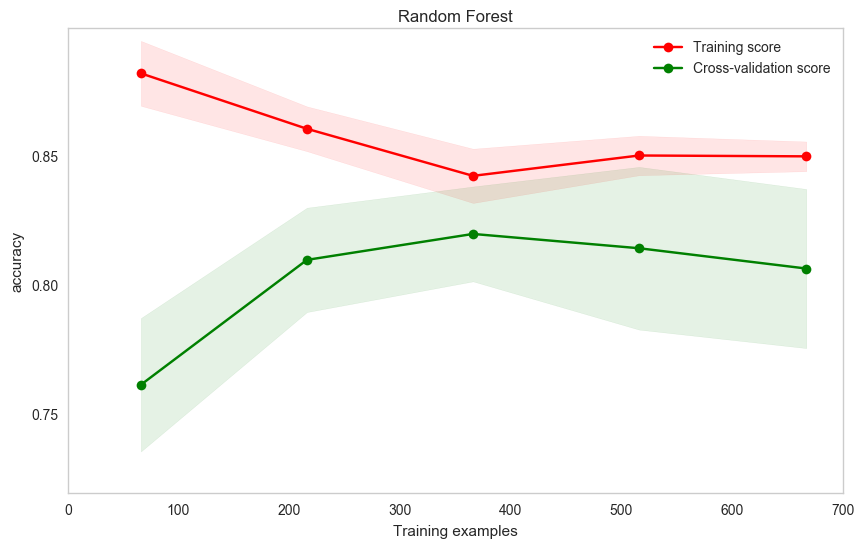

In [106]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))
plot_learning_curve(clf, 'Random Forest', X, y, cv=4);

In [107]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.8222222222222222
Fold 2 accuracy: 0.8651685393258427
Fold 3 accuracy: 0.7640449438202247
Fold 4 accuracy: 0.8764044943820225
Fold 5 accuracy: 0.8314606741573034
Fold 6 accuracy: 0.8426966292134831
Fold 7 accuracy: 0.7865168539325843
Fold 8 accuracy: 0.7865168539325843
Fold 9 accuracy: 0.8651685393258427
Fold 10 accuracy: 0.8539325842696629
Mean Accuracy: 0.8294132334581773


Повторим все выше описанные процедуры, которые мы делали для рандом фореста, теперь для логистической регрессии.

In [108]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=42, penalty='l1')
parameters = {'C':[0.5]}


# Type of scoring used to compare parameter combinations
acc_scorer_lg = make_scorer(accuracy_score)

# Run the grid search
grid_obj_lg = GridSearchCV(lg, parameters, scoring=acc_scorer_lg)
grid_obj_lg = grid_obj_lg.fit(X_train, y_train)

# Set the clf to the best combination of parameters
lg = grid_obj_lg.best_estimator_

# Fit the best algorithm to the data. 
lg.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.809701492537


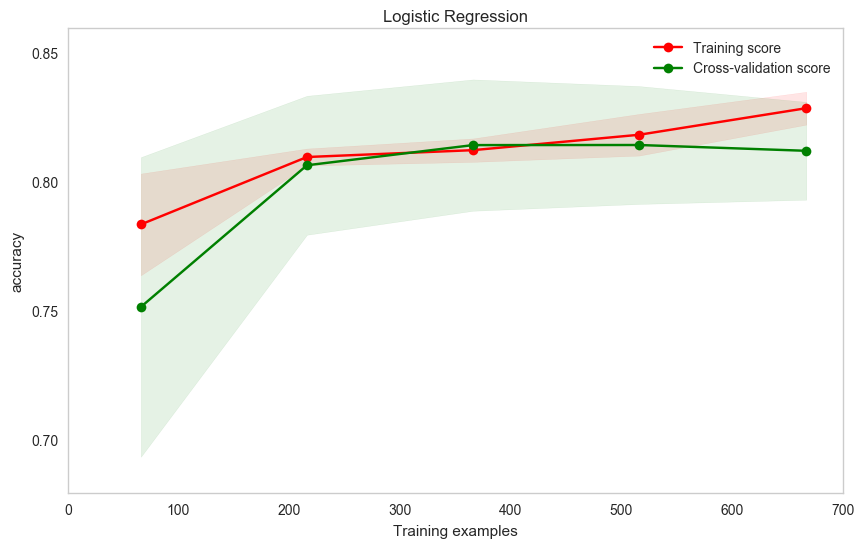

In [109]:
predictions_lg = lg.predict(X_test)
print(accuracy_score(y_test, predictions_lg))
plot_learning_curve(lg, 'Logistic Regression', X, y, cv=4);

Выбираем ту модель, которая нам больше понравилась и сабмитим ее на кагл.

In [110]:
ids = test_df['PassengerId']
predictions = clf.predict(test_df.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
